In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

In [2]:
# Load dataset
df = pd.read_csv("D:\Python Projects\Customer Segmentation Project\CC GENERAL.csv", index_col = 'CUST_ID')
# Check for missing values
print(df.isna().sum())

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


CREDIT_LIMIT only has 1 missing value and MINIMUM_PAYMENTS has 313 missing values. We will remove the missing value CREDIT_LIMIT column and for MINIMUM_PAYMENTS we will first identify customers whose payments are above and below the MINIMUM_PAYMENTS and then filling in the values for customers below MINIMUM_PAYMENTS with the mean of PAYMENTS.

In [3]:
#deleting missing value in credit_limit column
df.dropna(subset = ['CREDIT_LIMIT'], inplace = True)

df[['PAYMENTS', 'MINIMUM_PAYMENTS']][df['MINIMUM_PAYMENTS'].isna()]

#PAYMENTS that's above MINIMUM_PAYMENTS
print('Shape:', df[['PAYMENTS', 'MINIMUM_PAYMENTS']][(df['MINIMUM_PAYMENTS'].notna()) & (df['PAYMENTS'] > df['MINIMUM_PAYMENTS'])].shape)
df[['PAYMENTS', 'MINIMUM_PAYMENTS']][(df['MINIMUM_PAYMENTS'].notna()) & (df['PAYMENTS'] > df['MINIMUM_PAYMENTS'])].head()

#PAYMENTS that's below MINIMUM_PAYMENTS
print('Shape:', df[['PAYMENTS', 'MINIMUM_PAYMENTS']][(df['MINIMUM_PAYMENTS'].notna()) & (df['PAYMENTS'] < df['MINIMUM_PAYMENTS'])].shape)
df[['PAYMENTS', 'MINIMUM_PAYMENTS']][(df['MINIMUM_PAYMENTS'].notna()) & (df['PAYMENTS'] < df['MINIMUM_PAYMENTS'])].head()

#Fill missing values with the mean of payments column
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(), inplace=True)
df.isna().sum()

Shape: (6272, 2)
Shape: (2364, 2)


BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

Exploratory Data Analysis to get a look at the data

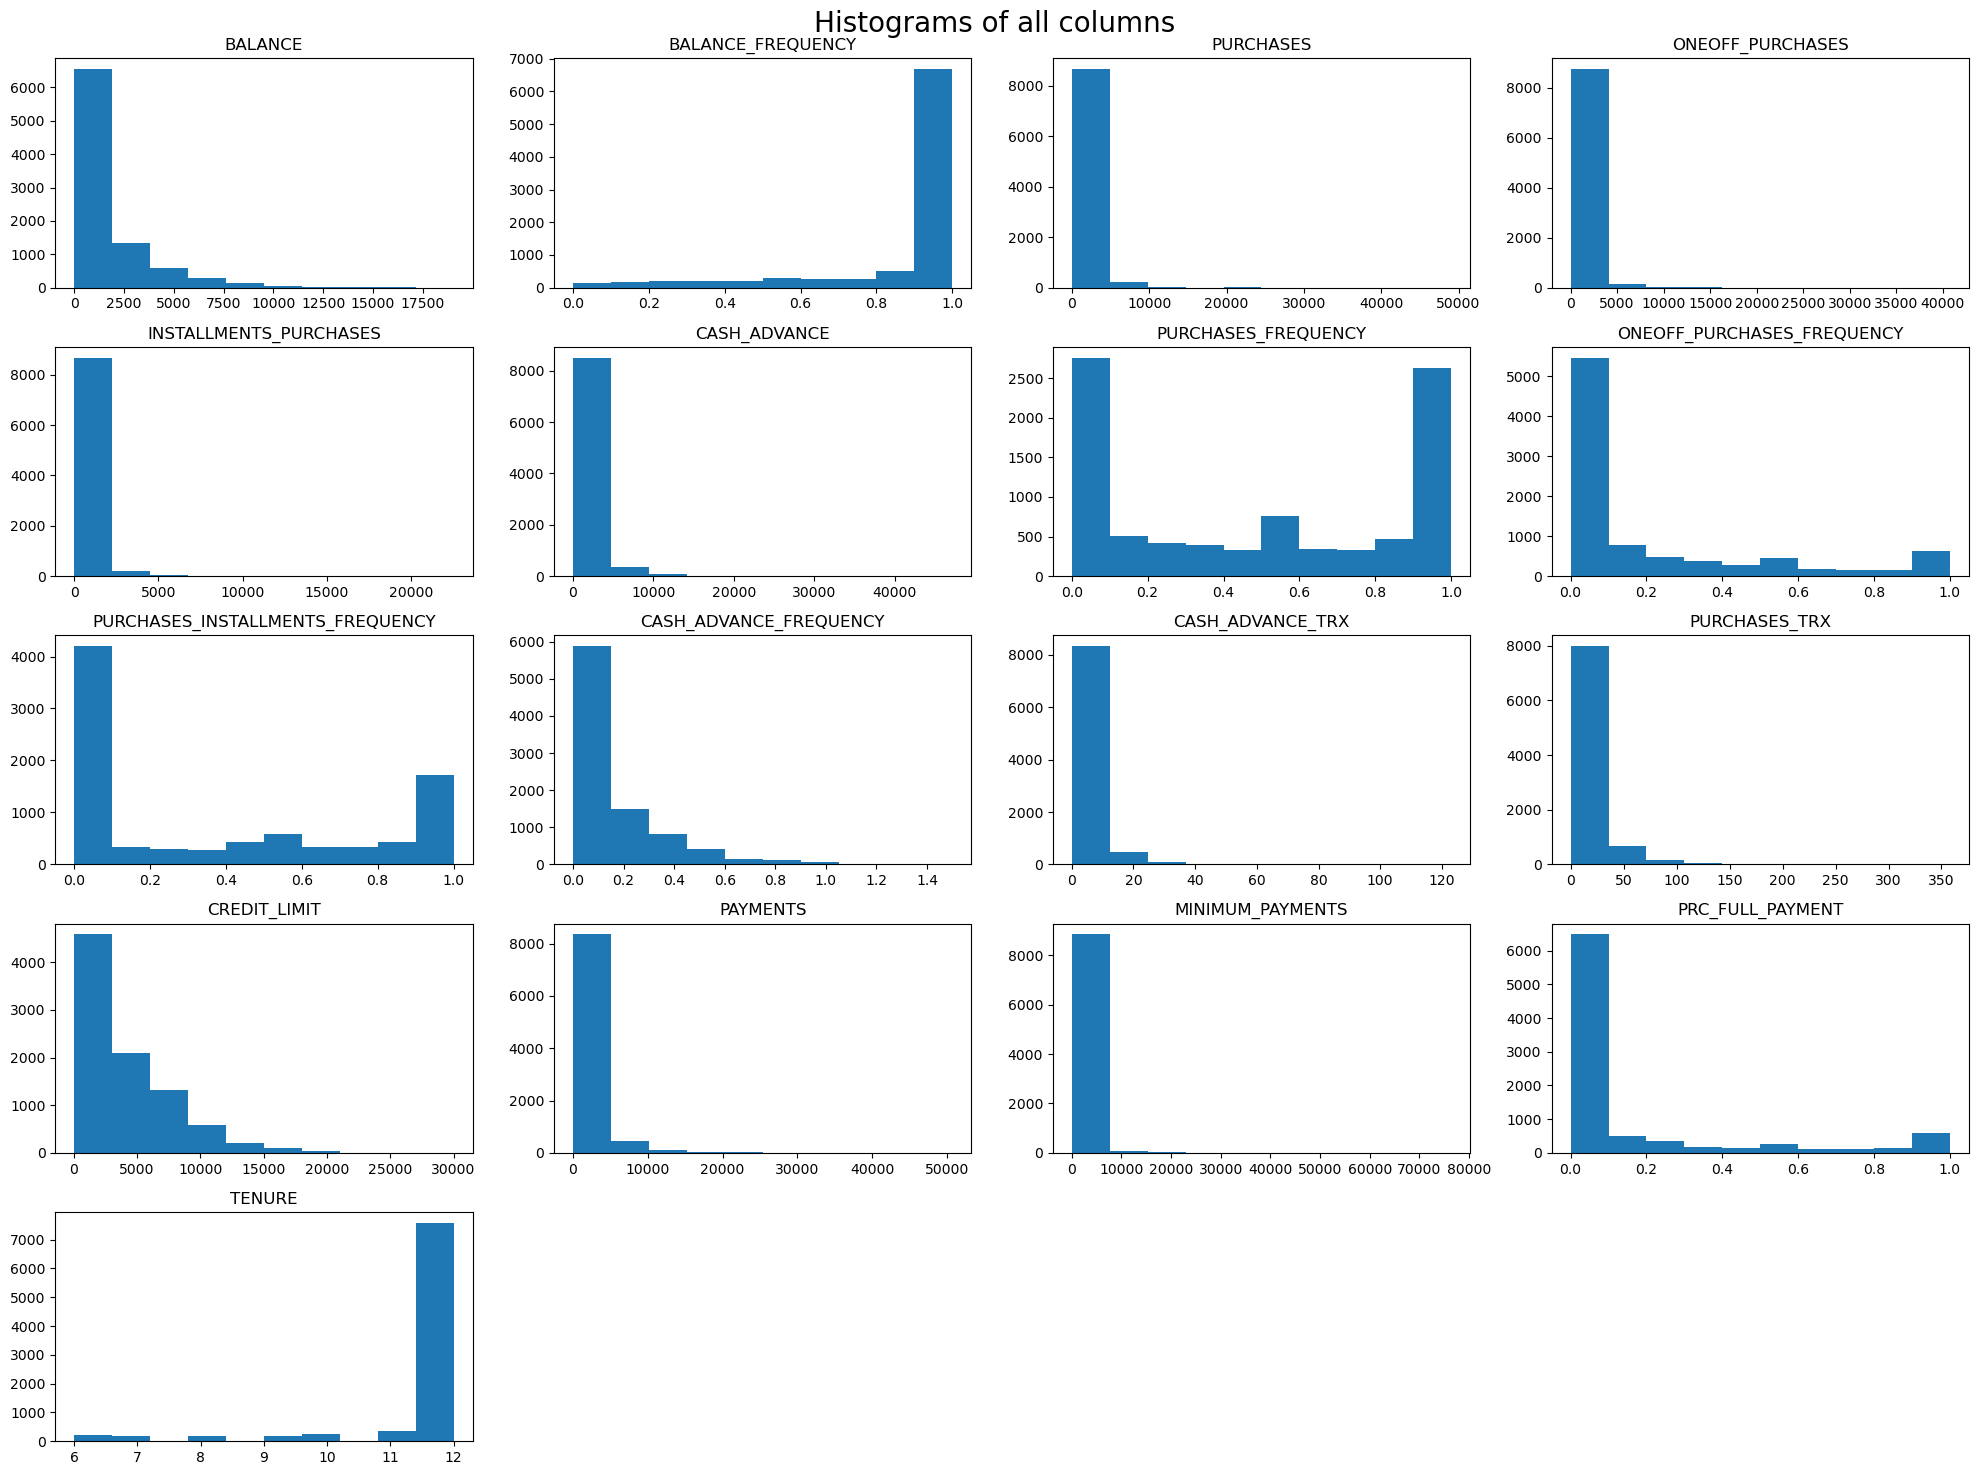

In [4]:
#getting a look at the data using exploratory data analysis
fig, ax = plt.subplots(5,4,figsize=(20, 15))
columns = df.columns
for index, col in enumerate(columns):
    row = index // 4
    col_position = index % 4
    if row < 5:
        ax[row, col_position].set_title(col)
        ax[row, col_position].hist(df[col])
    else:
        ax[row, col_position].axis('off')
fig.suptitle('Histograms of all columns', fontsize=20)
plt.tight_layout()

fig.delaxes(ax[4,2])
fig.delaxes(ax[4,3])
fig.delaxes(ax[4,1])

In [5]:
# Standardize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

Principal Component Analysis for Dimensionality Reduction

Text(0, 0.5, 'Explained Variance')

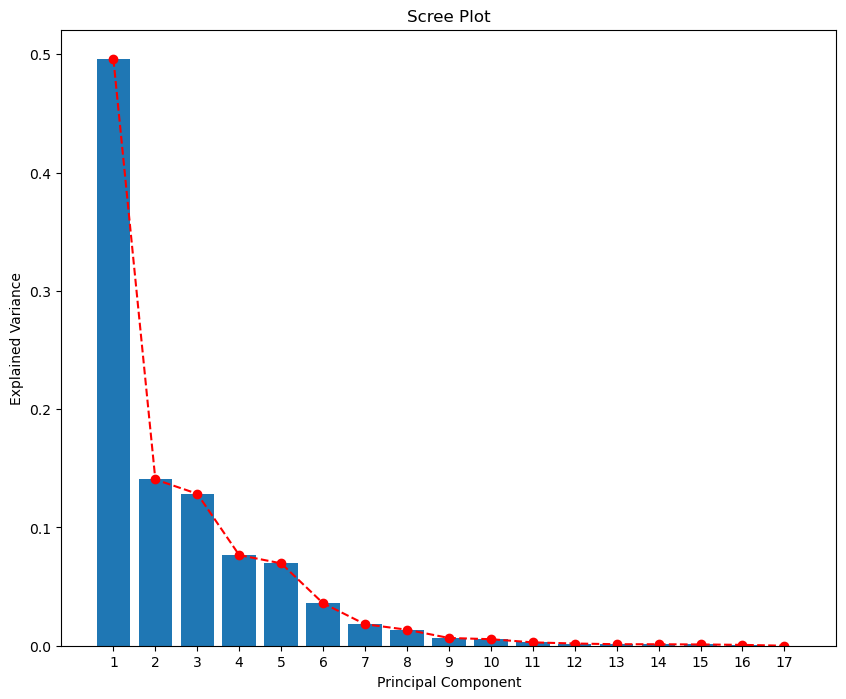

In [6]:
#identifying principal components of the data using PCA 
pca = PCA(n_components=17)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

#scree plot of percentage of explained variance vs each principal component
plt.figure(figsize=(10, 8))
plt.plot(range(1, 18), pca.explained_variance_ratio_, marker='o', linestyle='--', color='r')
plt.bar(range(1, 18), pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xticks(range(1, 18))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

Using K-means clustering to identify groups in the data 

In [7]:
#choosing first three components as they explain 80% of the variance
chosen_pca = pca_data[:, :3]

inertia = []
silh = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10,)
    kmeans.fit(chosen_pca)
    inertia.append(kmeans.inertia_)
    silh.append(silhouette_score(chosen_pca, kmeans.labels_))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range(2, 11), inertia, marker='o')
ax[0].set_title('Number of Clusters vs Inertia')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot(range(2, 11), silh, marker='o')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette Score')

Based on the silhoutte plot the data naturally forms 2-4 well-separated clusters, as indicated by the high silhouette scores in that range. The drop at k=5 likely means that forcing the data into 5 clusters may create poorly defined groupings with significant overlap.
The small recovery at k=8 suggests there might be some natural sub-clustering that appears when divided further, but it's still not as good as the simpler 2-4 cluster solution.
When combined with inertia plot it would be optimum to use 4 clusters to retain the quality. 

In [8]:
# Defining a fixed color mapping for clusters
cluster_palette = {0: "Red", 1: "Blue", 2: "Orange", 3: "Green"}
ordered_colors = [cluster_palette[i] for i in sorted(cluster_palette.keys())]
sns.set_palette(sns.color_palette(ordered_colors))

In [17]:
#adding cluster column to the dataframe
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)	
df['cluster'] = kmeans.fit_predict(chosen_pca)

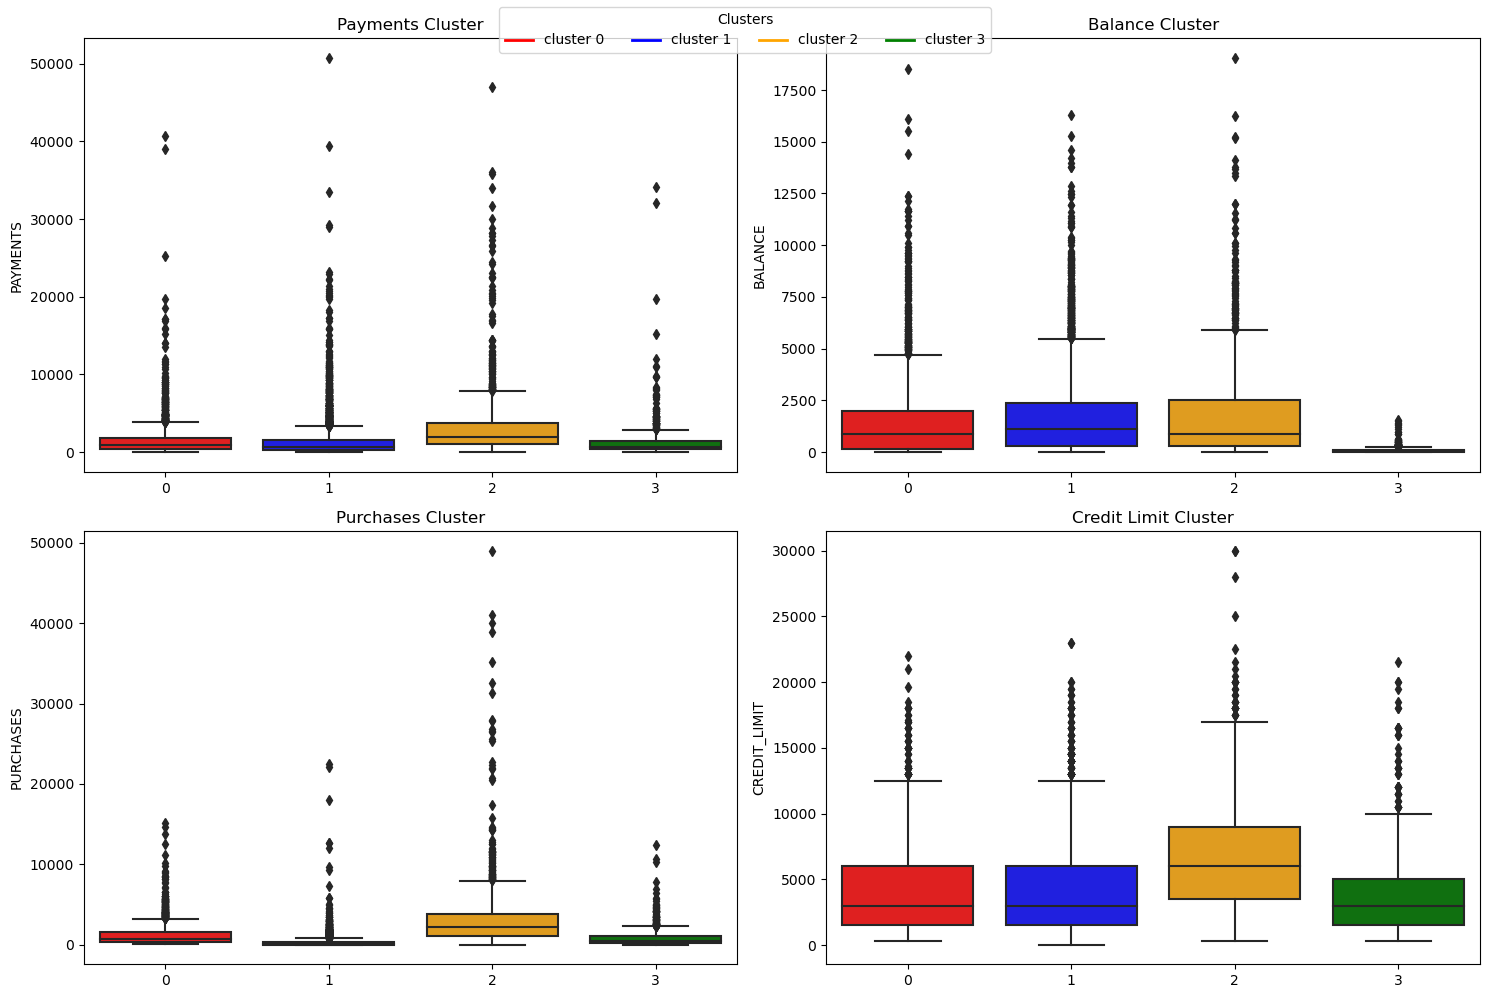

In [18]:
#1. Box Plot for Payments, Balance, Purchases and Credit Limit
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x='cluster', y='PAYMENTS', data=df, ax=ax[0, 0], palette=cluster_palette)
ax[0, 0].set_title("Payments Cluster")

sns.boxplot(x='cluster', y='BALANCE', data=df, ax=ax[0, 1], palette=cluster_palette)
ax[0, 1].set_title("Balance Cluster")

sns.boxplot(x='cluster', y='PURCHASES', data=df, ax=ax[1, 0], palette=cluster_palette)
ax[1, 0].set_title("Purchases Cluster")

sns.boxplot(x='cluster', y='CREDIT_LIMIT', data=df, ax=ax[1, 1], palette=cluster_palette)
ax[1, 1].set_title("Credit Limit Cluster")

# Remove the x-axis label for the boxplots
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel('')
# Plot legend for the clusters in the boxplot
handles = [plt.Line2D([0], [0], color=color, lw=2, label=f'cluster {i}') for i, color in cluster_palette.items()]
fig.legend(handles=handles, loc='upper center', ncol=len(cluster_palette), title="Clusters")
plt.tight_layout()

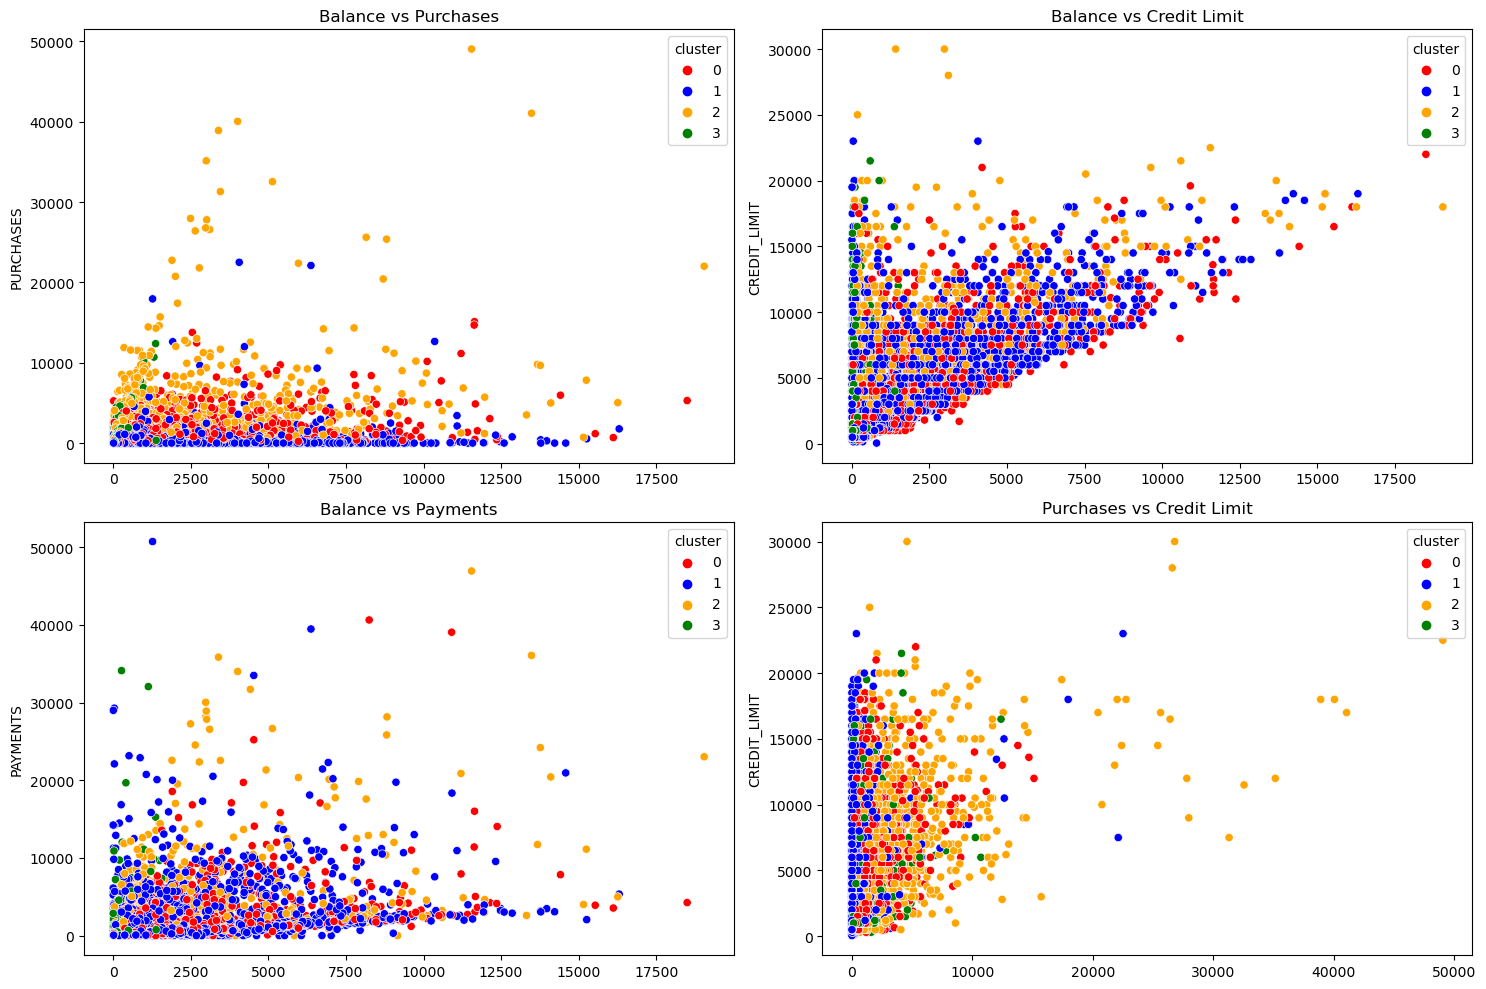

In [19]:
#2. Scatter Plot for Balance vs Purchases, Balance vs Credit Limit, Balance vs Payments, Purchases vs Credit Limit
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x='BALANCE', y='PURCHASES', hue='cluster', data=df, ax=ax[0, 0], palette=cluster_palette)
ax[0, 0].set_title("Balance vs Purchases")

sns.scatterplot(x='BALANCE', y='CREDIT_LIMIT', hue='cluster', data=df, ax=ax[0, 1], palette=cluster_palette)
ax[0, 1].set_title("Balance vs Credit Limit")

sns.scatterplot(x='BALANCE', y='PAYMENTS', hue='cluster', data=df, ax=ax[1, 0], palette=cluster_palette)
ax[1, 0].set_title("Balance vs Payments")

sns.scatterplot(x='PURCHASES', y='CREDIT_LIMIT', hue='cluster', data=df, ax=ax[1, 1], palette=cluster_palette)
ax[1, 1].set_title("Purchases vs Credit Limit")

# Remove the x-axis label for the scatter plots
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel('')
#plot legend
handles, labels = ax[0, 0].get_legend_handles_labels()
plt.tight_layout()


In [20]:
print(df['cluster'].value_counts())
print(df.groupby('cluster')[['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS']].mean())

1    4512
0    2230
2    1287
3     920
Name: cluster, dtype: int64
             BALANCE    PURCHASES  CREDIT_LIMIT     PAYMENTS
cluster                                                     
0        1550.234671  1185.707233   4106.780586  1570.465016
1        1781.924394   290.897509   4134.265192  1459.731240
2        1879.178871  3268.999223   6783.564314  3305.995885
3          93.980345   885.678880   3998.321311  1269.964554


In [ ]:
#get descriptive statistics of the cluster 0
# df[df['cluster'] == 0].describe()
# df[df['cluster'] == 1].describe()
# df[df['cluster'] == 2].describe()
# df[df['cluster'] == 3].describe()

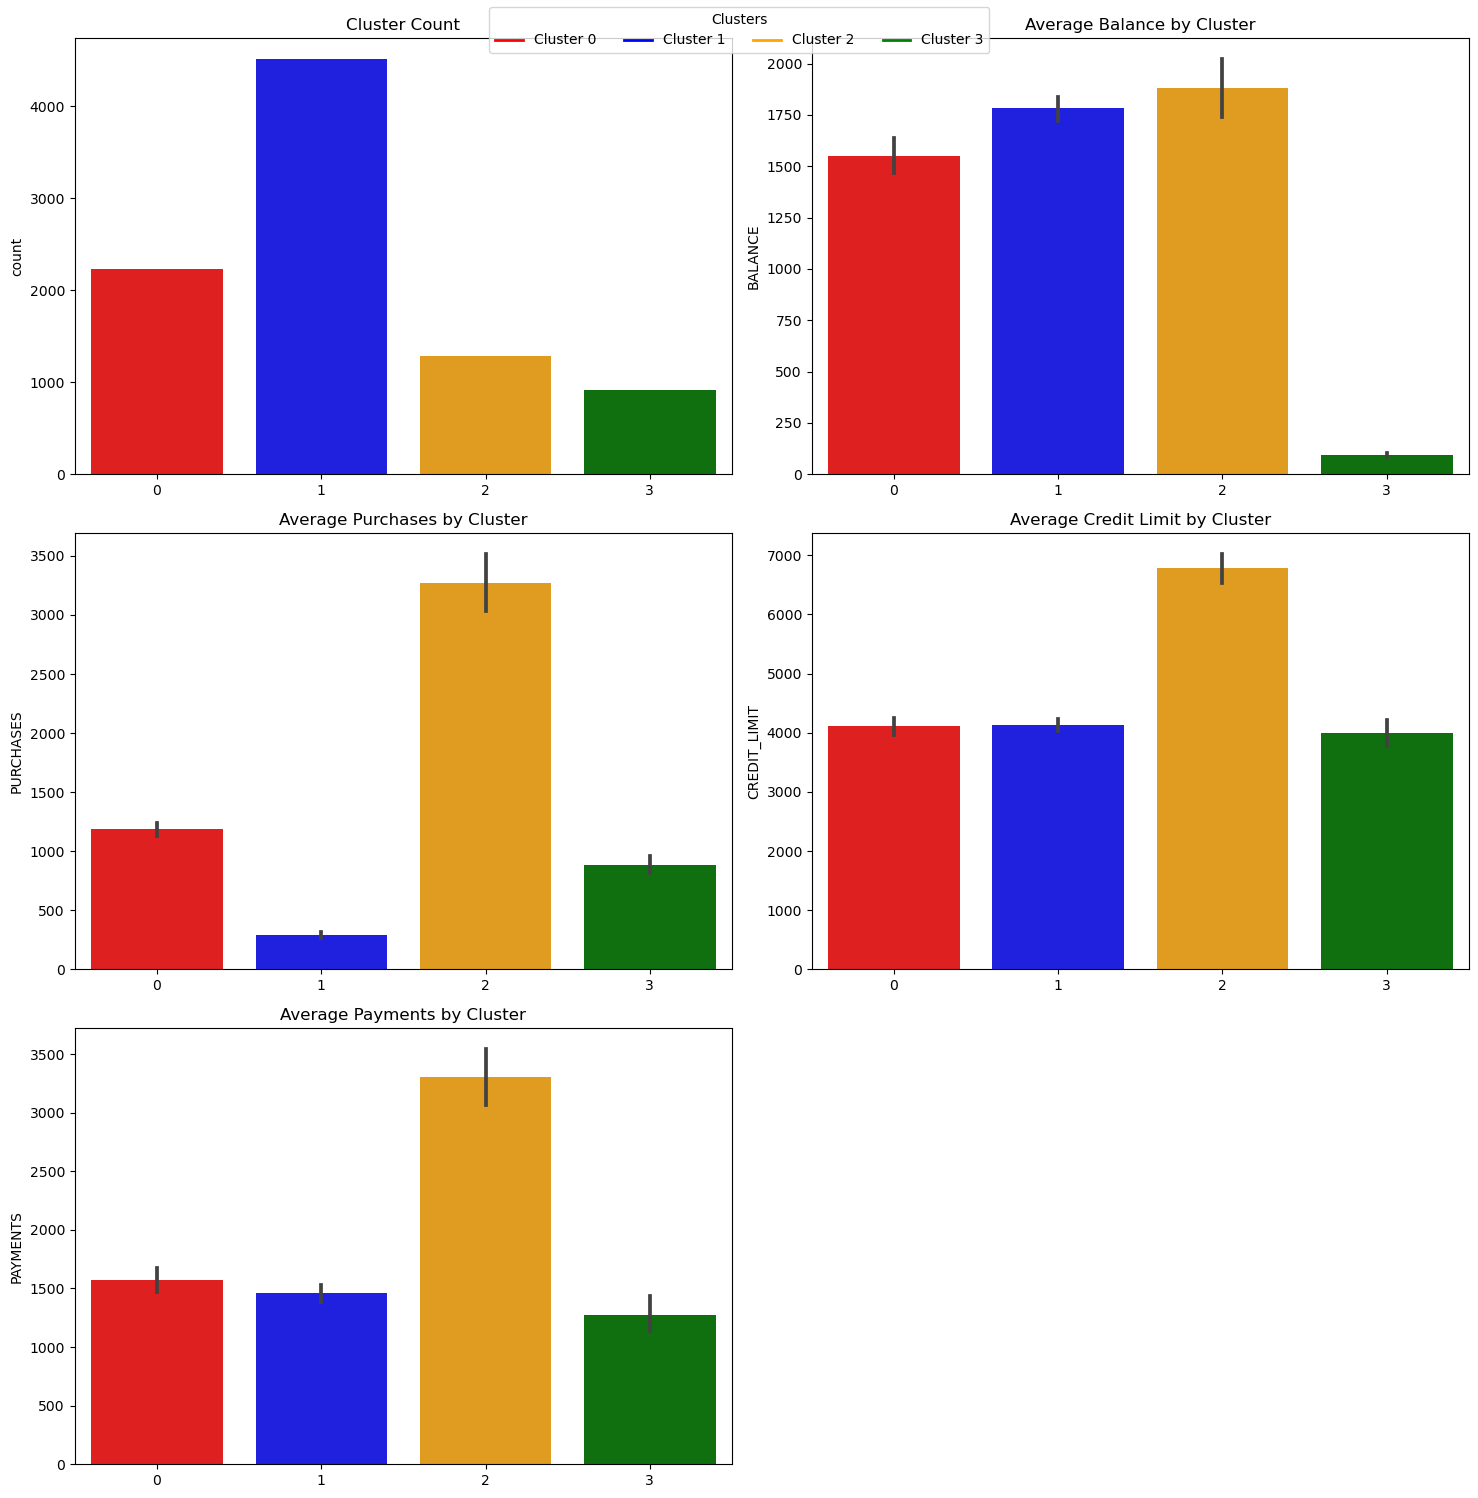

In [21]:
#3. Count and Average of Balance, Purchases and Credit Limit by Cluster 
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

sns.countplot(x="cluster", data=df, ax=ax[0, 0], palette=cluster_palette)
ax[0, 0].set_title("Cluster Count")

sns.barplot(x="cluster", y="BALANCE", data=df, ax=ax[0, 1], palette=cluster_palette)
ax[0, 1].set_title("Average Balance by Cluster")

sns.barplot(x="cluster", y="PURCHASES", data=df, ax=ax[1, 0], palette=cluster_palette)
ax[1, 0].set_title("Average Purchases by Cluster")

sns.barplot(x="cluster", y="CREDIT_LIMIT", data=df, ax=ax[1, 1], palette=cluster_palette)
ax[1, 1].set_title("Average Credit Limit by Cluster")

sns.barplot(x="cluster", y="PAYMENTS", data=df, ax=ax[2, 0], palette=cluster_palette)
ax[2, 0].set_title("Average Payments by Cluster")

# Remove the x-axis label for the bar plots
for i in range(3):
    for j in range(2):
        ax[i, j].set_xlabel('')

#plot legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=f'Cluster {i}') for i, color in cluster_palette.items()]
fig.legend(handles=handles, loc='upper center', ncol=len(cluster_palette), title="Clusters")
plt.tight_layout()

fig.delaxes(ax[2, 1])

Using Decision Tree Classifier to calculate accurancy 

In [22]:
# Define features and target
X = df.drop(columns=["cluster"])
y = df["cluster"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_pred = dt.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

Decision Tree Accuracy: 0.96


Analysis Interpretation: 

Key Observations:  
- Significant heterogeneity in financial behaviors
- Customers categorized into four distinct segments with each representing a unique financial profile 

Cluster 0: "Balanced Customers"  
Segment Profile  
Size: 2230 customers (second-largest, 25% of total)  

Financial Metrics:  
Moderate balance: $1550  
Moderate purchases  
Stable credit limit  
Consistent payment behavior  

Cluster 1: "Stable, Conservative Customers"   
Segment Profile  
Size: 4512 customers (largest, 52% of total)  

Financial Metrics:  
Steady average balance: $1782  
Lowest purchasing activity  
Moderate credit limit  

Cluster 2: "Premium Customers"   
Segment Profile  
Size: 1287 customers (28.5% of total)  

Financial Metrics:  
Highest average balance: $1879             
Highest average purchases: $3269          
Highest credit limit: $6784         
Highest average payments: $3306         

Cluster 3: "Emerging/Minimal Customers"   
Segment Profile  
Size: 920 customers (smallest, 10% of total)  

Financial Metrics:  
Extremely low balance: $94  
Low purchases and payments  
Lowest credit limit  